# Tracking particles in brightfield

**TL;DR** We developed a new method to more accurately track colloidal particles in bright field images that do not resemble Gaussian features.

The standard `locate` function in `trackpy` finds features by determining local maxima of intensity, thereby assuming the particles that need to be tracked have a Gaussian intensity distribution with a maximum in the center. While this is usually true for fluorescent particles, particles in bright field mode show a different intensity profile (see example images in this notebook).

Because the intensity profile is usually different from a Gaussian in bright field mode, the `locate` function fails to accurately find the center of the particle. We have developed a new method that uses the edge of the particle to more accurately refine the position of the center of the particle as detected by the standard `locate` function.

**Citing this work**
The algorithm we'll use is described in the following paper:
"Colloid supported lipid bilayers for self-assembly", M. Rinaldin, R.W. Verweij, I. Chakrabory, D.J. Kraft, Soft Matter (2019) [https://doi.org/10.1039/c8sm01661e](https://doi.org/10.1039/c8sm01661e). It is implemented in `trackpy` as `locate_brightfield_ring`. If you're using this code in your work, please cite both the paper and the appropriate `trackpy` version.

## Preliminary imports

In [2]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

We also might want to use scientific Python libraries. Finally, we'll import ``trackpy`` itself and its sister project, `pims`.

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
from pims import ND2_Reader
import trackpy as tp

## Step 1: Read the Data

### Opening images or video

We open the files with `pims`:

In [5]:
frames = ND2_Reader('Z:\\Hannah - vimentin networks\\m025\\210624_Vimentin_m025_p06_A_001.nd2')

C:\Users\rmcgorty\Anaconda3\lib\site-packages\pims\base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


In [6]:
micron_per_pixel = 0.13
feature_diameter = 1.0 # um
radius = int(np.round(feature_diameter/2.0/micron_per_pixel))
if radius % 2 == 0:
    radius += 1
print('Using a radius of {:d} px'.format(radius))
frames

Using a radius of 5 px


<FramesSequenceND>
Axes: 3
Axis 'x' size: 512
Axis 'y' size: 512
Axis 't' size: 5000
Pixel Datatype: <class 'numpy.uint16'>

These are colloidal particles diffusing in quasi-2D on a substrate. The images are cropped to focus on just five particles for 50 frames (approximately 7 seconds). Let's have a look a the first frame:

Frame([[39766, 39876, 40157, ..., 38626, 38564, 38845],
       [40002, 39809, 40371, ..., 38155, 38058, 38443],
       [40286, 40247, 40444, ..., 38381, 38064, 38371],
       ...,
       [39673, 39828, 40167, ..., 38973, 39123, 39041],
       [39778, 40075, 40162, ..., 38877, 39001, 39043],
       [40237, 40514, 40061, ..., 39399, 39038, 39386]], dtype=uint16)
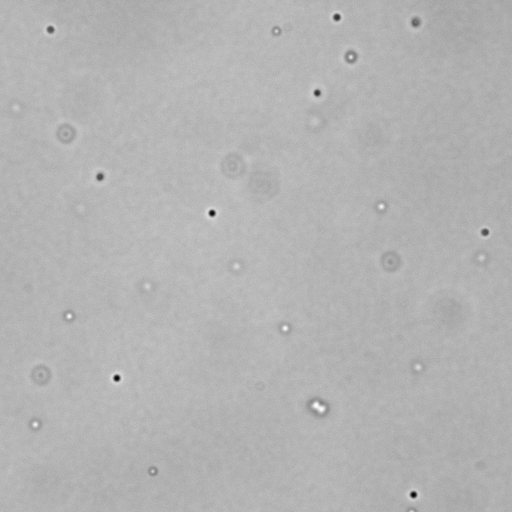

In [7]:
frames[0]

## Step 2: Locate Features

### Using the locate function

First, we'll try the standard `locate` function to find the particle positions:

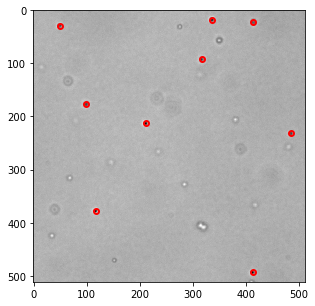

In [8]:
# we use a slightly larger radius
f_locate = tp.locate(frames[100], 9, minmass=100000, invert=True)
tp.annotate(f_locate, frames[100], plot_style={'markersize': radius});

In [9]:
f = tp.batch(frames[:5000], 9, minmass=100000, invert=True, processes=1)

Frame 4999: 9 features


In [10]:
t = tp.link(f, 5, memory=3)

Frame 4999: 9 trajectories present.


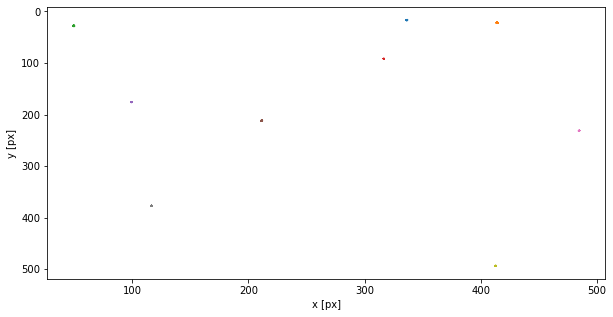

In [17]:
plt.figure()
tp.plot_traj(t);

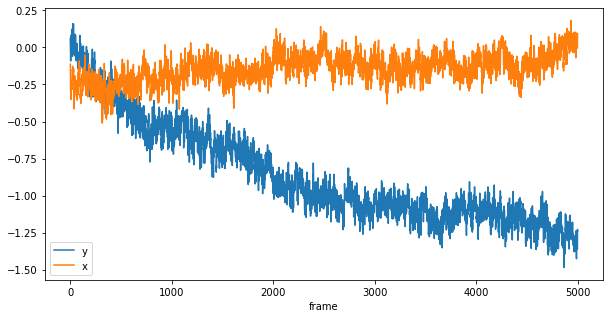

In [18]:
d = tp.compute_drift(t)
d.plot()
plt.show()

In [19]:
tm = tp.subtract_drift(t.copy(), d)

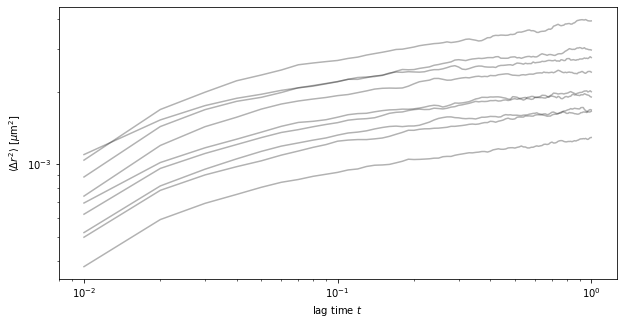

In [20]:
im = tp.imsd(tm, 0.13, 99.92)
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.3)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [21]:
em_dc = tp.emsd(tm, 0.13, 99.92, max_lagtime=1000)
em = tp.emsd(t, 0.13, 99.92, max_lagtime=1000)

Text(0.5, 1.0, 'm03\\210624_Vimentin_m03_p06_A_001')

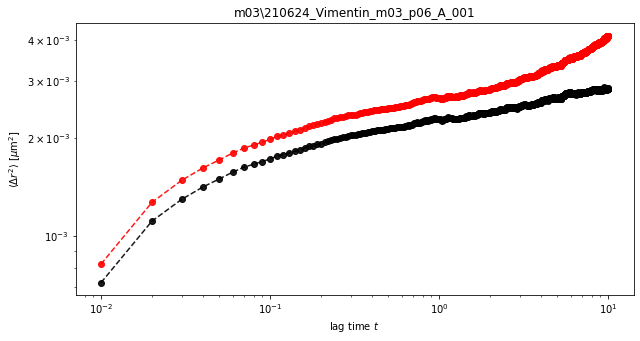

In [22]:
fig, ax = plt.subplots()
ax.loglog(em_dc.index, em_dc, '--ko', alpha=0.9)  # black lines, semitransparent
ax.loglog(em.index, em, '--ro', alpha=0.9)  # red lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.title("m03\\210624_Vimentin_m03_p06_A_001")
#ax.plot(em.index, (em.index**0.32) * 0.032, '-b')
#plt.axhline(y=0.024)

In [23]:
em.to_pickle("./210624_Vimentin_m025_p06_A1_not_drift_corrected_trackpy.pkl")
em_dc.to_pickle("./210624_Vimentin_m025_p06_A1_drift_corrected_trackpy.pkl")

In [34]:
tp.emsd?

All particle trajectories seem to be tracked. Let's zoom in a bit more to verify this:

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

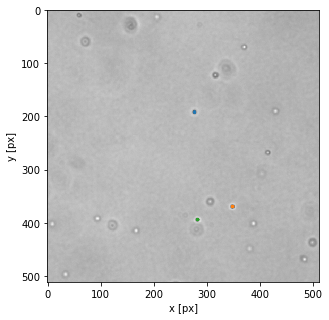

In [46]:
plt.figure()
background = np.mean(frames[0:10], axis=0)
tp.plot_traj(tm, superimpose=background, ax=plt.gca(), plot_style={'linewidth': 2})
#plt.ylim(0, 150)
#plt.xlim(200, 450);

Alternatively, you can use [Pimsviewer](https://github.com/soft-matter/pimsviewer#example-03-annotating-features-on-a-video) to overlay the positions on your video to check if the tracking has succeeded. Now you can analyse your data using the accurate center positions of the particles.

# About this work

This tutorial was written by Ruben Verweij, as part of his PhD thesis in Daniela Kraft’s group at the Huygens-Kamerlingh-Onnes laboratory, Institute of Physics, Leiden University, The Netherlands. This work was supported by the Netherlands Organisation for Scientific Research (NWO/OCW) and the European Research Council (ERC).

**Citing this work**
The algorithm is described in the following paper:
"Colloid supported lipid bilayers for self-assembly", M. Rinaldin, R.W. Verweij, I. Chakrabory, D.J. Kraft, Soft Matter (2019) [https://doi.org/10.1039/c8sm01661e](https://doi.org/10.1039/c8sm01661e). It is implemented in `trackpy` as `locate_brightfield_ring`. If you're using this code in your work, please cite both the paper and the appropriate `trackpy` version.